In [156]:
import pandas as pd
import numpy as np
import bisect
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from datetime import datetime

pd.set_option('display.float_format', lambda x: '%.6f' % x)
pd.options.mode.chained_assignment = None  # default='warn'

# Utilities Functions

In [217]:
def read_dataset():
    """

    :return: Complete dataset
    """
    df = pd.read_csv('Glucose_measurements_sample.csv',
                      dtype={'Glucose_measurements': int})
    add_features(df)

    return df

def add_features(df):
    """

    :param df:
    :return: Add a unify temporal and date column
    """
    df["Time"] = pd.to_datetime(df["Measurement_date"] + ' '
                                + df["Measurement_time"])

def get_patient_ids(df=None):
    """

    :param df_glucose:
    :return: List of patient ids
    """
    if df is None:
        df = read_dataset()
    return df['Patient_ID'].unique()


In [223]:
# Return a dataset with lagged col of df and the difference
def get_lagged_col(df, col, new_col_name, diff_name, diff_time_treatment = False,
                   absolute_value = False):
    """
    :param df: Dataframe to lagg, if not all dataset
    :param col: Column to lag
    :param new_col_name: New name of lagged column
    :param diff_name: Name of diff column
    :param diff_time_treatment: Time difference treatment
    :param absolute_value: If true abs value diff
    :return: A df with three columns: col, col-1 and difference


    """
    df[f"{new_col_name}-1"] = df.groupby(['Patient_ID'])[col].shift(1)
    df = df.rename(columns={col: new_col_name})

    # Create diff col
    df[diff_name] = df[new_col_name] - df[f"{new_col_name}-1"]
    if absolute_value:
        df[diff_name] = abs(df[diff_name])
    if diff_time_treatment:
        df[diff_name] = df[diff_name] / np.timedelta64(1, 'm')

    return df

def update_lag_cols(df, measurement_col = True, time_col = True):
    '''

    :param time_col:
    :param measurement_col:
    :param df:
    :return: df with updated lag columns and diffs
    '''
    # Updating diff cols
    if time_col:
        df.drop('Minutes_diff', inplace=True, axis=1)
        df.drop('t-1', inplace=True, axis=1)
        df = get_lagged_col(df=df, col="t", new_col_name="t",
                           diff_time_treatment=True, diff_name="Minutes_diff")
    if measurement_col:
        df.drop('Measurement_diff', inplace=True, axis=1)
        df.drop('Measurement-1', inplace=True, axis=1)
        df = get_lagged_col(df=df, col="Measurement", new_col_name="Measurement",
                                absolute_value=True, diff_name="Measurement_diff")
    return df

# Reading complete dataset and creating cols lagged for time and measurements

In [193]:
df_glucose = read_dataset()
complete_df_glucose = df_glucose.copy()
df_glucose_lag = get_lagged_col(df=df_glucose, col="Time", new_col_name="t",
                           diff_time_treatment=True, diff_name="Minutes_diff")
df_glucose_lag = get_lagged_col(df=df_glucose_lag, col="Measurement", new_col_name="Measurement",
                                absolute_value=True, diff_name="Measurement_diff")
# Removing first row (Nan) for each patient
#df_glucose_lag = df_glucose_lag.dropna()

In [194]:
complete_df_glucose

,Patient_ID,Measurement_date,Measurement_time,Measurement,Time
0,LIB193263,2020-06-09,19:08:00,99,2020-06-09 19:08:00
1,LIB193263,2020-06-09,19:23:00,92,2020-06-09 19:23:00
2,LIB193263,2020-06-09,19:38:00,86,2020-06-09 19:38:00
3,LIB193263,2020-06-09,19:53:00,85,2020-06-09 19:53:00
4,LIB193263,2020-06-09,20:08:00,85,2020-06-09 20:08:00
...,...,...,...,...,...
2999995,LIB193424,2022-01-02,01:05:00,207,2022-01-02 01:05:00
2999996,LIB193424,2022-01-02,01:20:00,215,2022-01-02 01:20:00
2999997,LIB193424,2022-01-02,01:35:00,218,2022-01-02 01:35:00
2999998,LIB193424,2022-01-02,01:50:00,222,2022-01-02 01:50:00


In [195]:
df_glucose_lag.shape[0]

3000000

# Identification of Duplicated Samples
## Context
Duplicated samples are duplicated rows


In [196]:
duplicated = df_glucose_lag.duplicated().sum()
duplicated

0

# Outliers 1
## Context
Probably, a good idea for working outliers is analyzed 15 minutes changes in
BG values.
## Idea
Delete rows with time difference about 15 minutes and absurd BG values changes


We can consider an upper bound considering possible delays i.e. 15 minutes + 3 minutes.
About lower bound, we can think if 100 BG differences is an extreme change for
15 minutes, for less time it would be more extraordinary and more
probable to be an outlier.


In [197]:
## Getting BG differences only for consecutive (15 min + delay) values
df_glucose_no_gaps = df_glucose_lag[ (df_glucose_lag["Minutes_diff"] < 18.0)]
df_glucose_no_gaps.shape[0]

2973284

In [198]:
# Getting number of outliers (BG diff > 100 mg/dL) fo consecutive measurements
df_glucose_outliers = df_glucose_no_gaps[df_glucose_no_gaps['Measurement_diff'] > 100.0]
df_glucose_outliers

,Patient_ID,Measurement_date,Measurement_time,Measurement,t,t-1,Minutes_diff,Measurement-1,Measurement_diff
91140,LIB193265,2019-06-20,08:12:00,245,2019-06-20 08:12:00,2019-06-20 07:56:00,16.000000,349.000000,104.000000
136903,LIB193266,2020-11-14,12:42:00,233,2020-11-14 12:42:00,2020-11-14 12:27:00,15.000000,102.000000,131.000000
136904,LIB193266,2020-11-14,12:42:00,108,2020-11-14 12:42:00,2020-11-14 12:42:00,0.000000,233.000000,125.000000
136905,LIB193266,2020-11-14,12:57:00,259,2020-11-14 12:57:00,2020-11-14 12:42:00,15.000000,108.000000,151.000000
138323,LIB193266,2020-11-30,11:41:00,141,2020-11-30 11:41:00,2020-11-30 11:27:00,14.000000,300.000000,159.000000
...,...,...,...,...,...,...,...,...,...
2918552,LIB193416,2022-03-07,11:04:00,214,2022-03-07 11:04:00,2022-03-07 10:59:00,5.000000,99.000000,115.000000
2918553,LIB193416,2022-03-07,11:14:00,86,2022-03-07 11:14:00,2022-03-07 11:04:00,10.000000,214.000000,128.000000
2918554,LIB193416,2022-03-07,11:20:00,210,2022-03-07 11:20:00,2022-03-07 11:14:00,6.000000,86.000000,124.000000
2918555,LIB193416,2022-03-07,11:30:00,74,2022-03-07 11:30:00,2022-03-07 11:20:00,10.000000,210.000000,136.000000


In [199]:
df_glucose_outliers.shape[0]

5461

In [200]:
# Calculating the representation of the outliers in the complete dataset
outliers_representation = df_glucose_outliers.shape[0] / df_glucose.shape[0]
outliers_representation


0.0018203333333333333

## Checking if medical assumptions (100 mg/dL) has correspondence to our data

In [201]:
df_glucose_no_gaps.describe()

,Measurement,Minutes_diff,Measurement-1,Measurement_diff
count,2973284.000000,2973284.000000,2973284.000000,2973284.000000
mean,158.893065,14.771750,158.946504,9.424736
std,65.388476,1.639832,65.401646,11.440756
min,40.000000,0.000000,40.000000,0.000000
25%,110.000000,15.000000,110.000000,3.000000
50%,148.000000,15.000000,148.000000,6.000000
75%,197.000000,15.000000,197.000000,12.000000
max,500.000000,17.000000,500.000000,355.000000


In [202]:
df_glucose_no_gaps.quantile([.25,.50,.75,.85,.90,.95,.99,.995,.9975,.998])

,Measurement,Minutes_diff,Measurement-1,Measurement_diff
0.250000,110.000000,15.000000,110.000000,3.000000
0.500000,148.000000,15.000000,148.000000,6.000000
0.750000,197.000000,15.000000,197.000000,12.000000
0.850000,227.000000,15.000000,227.000000,17.000000
0.900000,248.000000,15.000000,248.000000,21.000000
0.950000,281.000000,15.000000,281.000000,28.000000
0.990000,350.000000,16.000000,350.000000,48.000000
0.995000,379.000000,17.000000,379.000000,60.000000
0.997500,407.000000,17.000000,407.000000,85.000000
0.998000,416.000000,17.000000,416.000000,96.000000


# Outliers 2

## Remove outliers based on isolated extreme value. Not done bc important information would be removed.

[Text(0.5, 1.0, 'BG values histogram')]

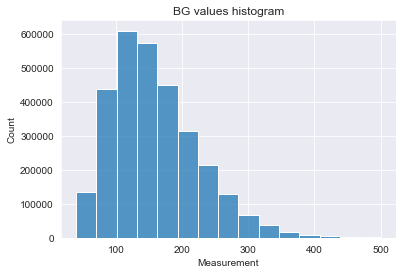

In [203]:
# Histogram

sns.histplot(data=df_glucose, x="Measurement", bins=15).set(title='BG values histogram')

# Resampling

## Multiple Measurements in the Same Interval (Downsampling)
The idea is to consider intervals of 15 minutes. Each interval of 15 minutes should have only one measurement, so
inside each interval only one value will be selected

In [204]:
# Added an index col
df_glucose_lag['index'] = df_glucose_lag.index

Not all the samples have the same frequency: There are variations in sampling i.e. 16 minutes instead of 15 minutes.
For this reason, it is not possible to generate all intervals based on the first sample of each patient.
Each time the frequency change, the start point of the intervals should be restarted.

Example:

The ranges are divided by --------------------

Minutes_diff     Measurement

Nan                 65              Start point

-----------------------------------------------------

15                  70

5                   72

-----------------------------------------------------

10                  75

-----------------------------------------------------

16                  90              At this point the start point is restarted

The indexes where the frequency change are calculated below

In [207]:
frequency_variations_indexes = df_glucose_lag[(df_glucose_lag['Minutes_diff'] > 15) | (df_glucose_lag['Minutes_diff'].isna())].index
frequency_variations_indexes

Int64Index([      0,      59,     211,     279,     387,     474,     499,
                564,     594,     653,
            ...
            2999896, 2999905, 2999941, 2999948, 2999954, 2999965, 2999973,
            2999985, 2999989, 2999992],
           dtype='int64', length=167201)

A new column is added to represent the frequency set of each sample

In [210]:
def find_index_position(indexes_list, index):
    """
    :return: Position + 1 of the index in ordered indexs_list
    """
    return np.searchsorted(indexes_list, index, 'right')

# Compute the positions of each value in the `index` column relative to `frequency_variations`
positions = find_index_position(frequency_variations_indexes, df_glucose_lag['index'])

df_glucose_lag['Frequency'] = positions
df_glucose_lag

,Patient_ID,Measurement_date,Measurement_time,Measurement,t,t-1,Minutes_diff,Measurement-1,Measurement_diff,index,Frequency
0,LIB193263,2020-06-09,19:08:00,99,2020-06-09 19:08:00,NaT,NaN,NaN,NaN,0,1
1,LIB193263,2020-06-09,19:23:00,92,2020-06-09 19:23:00,2020-06-09 19:08:00,15.000000,99.000000,7.000000,1,1
2,LIB193263,2020-06-09,19:38:00,86,2020-06-09 19:38:00,2020-06-09 19:23:00,15.000000,92.000000,6.000000,2,1
3,LIB193263,2020-06-09,19:53:00,85,2020-06-09 19:53:00,2020-06-09 19:38:00,15.000000,86.000000,1.000000,3,1
4,LIB193263,2020-06-09,20:08:00,85,2020-06-09 20:08:00,2020-06-09 19:53:00,15.000000,85.000000,0.000000,4,1
...,...,...,...,...,...,...,...,...,...,...,...
2999995,LIB193424,2022-01-02,01:05:00,207,2022-01-02 01:05:00,2022-01-02 00:50:00,15.000000,186.000000,21.000000,2999995,167201
2999996,LIB193424,2022-01-02,01:20:00,215,2022-01-02 01:20:00,2022-01-02 01:05:00,15.000000,207.000000,8.000000,2999996,167201
2999997,LIB193424,2022-01-02,01:35:00,218,2022-01-02 01:35:00,2022-01-02 01:20:00,15.000000,215.000000,3.000000,2999997,167201
2999998,LIB193424,2022-01-02,01:50:00,222,2022-01-02 01:50:00,2022-01-02 01:35:00,15.000000,218.000000,4.000000,2999998,167201


Now we know the frequency changes, it is possible to do the downsampling process
For each group of measurements in the same Interval, the mean of all of them is selected as the new and unique value for this range.

In [245]:
df_glucose_t = df_glucose_lag.set_index('t')
#Resampling
df_glucose_resampled = df_glucose_t.groupby(["Patient_ID","Frequency"]).resample("15T").mean()
df_glucose_resampled

Measurement  Minutes_diff  \
Patient_ID Frequency t                                                
LIB193263  1         2020-06-09 19:00:00    99.000000           NaN   
                     2020-06-09 19:15:00    92.000000     15.000000   
                     2020-06-09 19:30:00    86.000000     15.000000   
                     2020-06-09 19:45:00    85.000000     15.000000   
                     2020-06-09 20:00:00    85.000000     15.000000   
...                                               ...           ...   
LIB193424  167201    2022-01-02 01:00:00   207.000000     15.000000   
                     2022-01-02 01:15:00   215.000000     15.000000   
                     2022-01-02 01:30:00   218.000000     15.000000   
                     2022-01-02 01:45:00   222.000000     15.000000   
                     2022-01-02 02:00:00   220.000000     15.000000   

                                          Measurement-1  Measurement_diff  \
Patient_ID Frequency t                                                      
LIB193263  1         2020-06-09 19:00:00            NaN               NaN   
                     2020-06-09 19:15:00      99.000000          7.000000   
                     2020-06-09 19:30:00      92.000000          6.000000   
                     2020-06-09 19:45:00      86.000000          1.000000   
                     2020-06-09 20:00:00      85.000000          0.000000   
...                                                 ...               ...   
LIB193424  167201    2022-01-02 01:00:00     186.000000         21.000000   
                     2022-01-02 01:15:00     207.000000          8.000000   
                     2022-01-02 01:30:00     215.000000          3.000000   
                     2022-01-02 01:45:00     218.000000          4.000000   
                     2022-01-02 02:00:00     222.000000          2.000000   

                                                  index     Frequency  
Patient_ID Frequency t                                                 
LIB193263  1         2020-06-09 19:00:00       0.000000      1.000000  
                     2020-06-09 19:15:00       1.000000      1.000000  
                     2020-06-09 19:30:00       2.000000      1.000000  
                     2020-06-09 19:45:00       3.000000      1.000000  
                     2020-06-09 20:00:00       4.000000      1.000000  
...                                                 ...           ...  
LIB193424  167201    2022-01-02 01:00:00 2999995.000000 167201.000000  
                     2022-01-02 01:15:00 2999996.000000 167201.000000  
                     2022-01-02 01:30:00 2999997.000000 167201.000000  
                     2022-01-02 01:45:00 2999998.000000 167201.000000  
                     2022-01-02 02:00:00 2999999.000000 167201.000000  

[2943964 rows x 6 columns]

In [262]:
# Undoing the groupby 'Patient_ID', 'Frequency' and the index 't'
df_downsampled = df_glucose_resampled.reset_index(level=0)
df_downsampled = df_downsampled.reset_index(level=0, drop=True)
df_downsampled = df_downsampled.reset_index()
df_downsampled

,t,Patient_ID,Measurement,Minutes_diff,Measurement-1,Measurement_diff,index,Frequency
0,2020-06-09 19:00:00,LIB193263,99.000000,NaN,NaN,NaN,0.000000,1.000000
1,2020-06-09 19:15:00,LIB193263,92.000000,15.000000,99.000000,7.000000,1.000000,1.000000
2,2020-06-09 19:30:00,LIB193263,86.000000,15.000000,92.000000,6.000000,2.000000,1.000000
3,2020-06-09 19:45:00,LIB193263,85.000000,15.000000,86.000000,1.000000,3.000000,1.000000
4,2020-06-09 20:00:00,LIB193263,85.000000,15.000000,85.000000,0.000000,4.000000,1.000000
...,...,...,...,...,...,...,...,...
2943959,2022-01-02 01:00:00,LIB193424,207.000000,15.000000,186.000000,21.000000,2999995.000000,167201.000000
2943960,2022-01-02 01:15:00,LIB193424,215.000000,15.000000,207.000000,8.000000,2999996.000000,167201.000000
2943961,2022-01-02 01:30:00,LIB193424,218.000000,15.000000,215.000000,3.000000,2999997.000000,167201.000000
2943962,2022-01-02 01:45:00,LIB193424,222.000000,15.000000,218.000000,4.000000,2999998.000000,167201.000000


In [264]:
# Recalulating the lagged cols
df_downsampled = get_lagged_col(df=df_downsampled, col="t", new_col_name="t",
                           diff_time_treatment=True, diff_name="Minutes_diff")
df_downsampled = get_lagged_col(df=df_downsampled, col="Measurement", new_col_name="Measurement",
                                absolute_value=True, diff_name="Measurement_diff")

df_downsampled

,t,Patient_ID,Measurement,Minutes_diff,Measurement-1,Measurement_diff,index,Frequency,t-1
0,2020-06-09 19:00:00,LIB193263,99.000000,NaN,NaN,NaN,0.000000,1.000000,NaT
1,2020-06-09 19:15:00,LIB193263,92.000000,15.000000,99.000000,7.000000,1.000000,1.000000,2020-06-09 19:00:00
2,2020-06-09 19:30:00,LIB193263,86.000000,15.000000,92.000000,6.000000,2.000000,1.000000,2020-06-09 19:15:00
3,2020-06-09 19:45:00,LIB193263,85.000000,15.000000,86.000000,1.000000,3.000000,1.000000,2020-06-09 19:30:00
4,2020-06-09 20:00:00,LIB193263,85.000000,15.000000,85.000000,0.000000,4.000000,1.000000,2020-06-09 19:45:00
...,...,...,...,...,...,...,...,...,...
2943959,2022-01-02 01:00:00,LIB193424,207.000000,15.000000,186.000000,21.000000,2999995.000000,167201.000000,2022-01-02 00:45:00
2943960,2022-01-02 01:15:00,LIB193424,215.000000,15.000000,207.000000,8.000000,2999996.000000,167201.000000,2022-01-02 01:00:00
2943961,2022-01-02 01:30:00,LIB193424,218.000000,15.000000,215.000000,3.000000,2999997.000000,167201.000000,2022-01-02 01:15:00
2943962,2022-01-02 01:45:00,LIB193424,222.000000,15.000000,218.000000,4.000000,2999998.000000,167201.000000,2022-01-02 01:30:00


In [282]:
df_downsampled[df_downsampled['Minutes_diff'] > 18]

,t,Patient_ID,Measurement,Minutes_diff,Measurement-1,Measurement_diff,index,Frequency,t-1
211,2020-06-12 00:00:00,LIB193263,147.000000,30.000000,155.000000,8.000000,211.000000,3.000000,2020-06-11 23:30:00
278,2020-06-12 17:00:00,LIB193263,111.000000,30.000000,123.000000,12.000000,279.000000,4.000000,2020-06-12 16:30:00
497,2020-06-15 00:00:00,LIB193263,186.000000,30.000000,197.000000,11.000000,499.000000,7.000000,2020-06-14 23:30:00
592,2020-06-16 00:00:00,LIB193263,90.000000,30.000000,95.000000,5.000000,594.000000,9.000000,2020-06-15 23:30:00
743,2020-06-17 14:00:00,LIB193263,169.000000,30.000000,150.000000,19.000000,746.000000,12.000000,2020-06-17 13:30:00
...,...,...,...,...,...,...,...,...,...
2943678,2021-12-30 01:00:00,LIB193424,261.000000,120.000000,113.000000,148.000000,2999714.000000,167177.000000,2021-12-29 23:00:00
2943768,2021-12-31 00:00:00,LIB193424,212.000000,45.000000,213.000000,1.000000,2999804.000000,167185.000000,2021-12-30 23:15:00
2943807,2021-12-31 10:00:00,LIB193424,156.000000,30.000000,161.000000,5.000000,2999843.000000,167186.000000,2021-12-31 09:30:00
2943937,2022-01-01 18:45:00,LIB193424,193.000000,30.000000,187.000000,6.000000,2999973.000000,167198.000000,2022-01-01 18:15:00


In [283]:
df_glucose_lag[df_glucose_lag['Minutes_diff'] > 18]

,Patient_ID,Measurement_date,Measurement_time,Measurement,t,t-1,Minutes_diff,Measurement-1,Measurement_diff,index,Frequency
211,LIB193263,2020-06-12,00:01:00,147,2020-06-12 00:01:00,2020-06-11 23:32:00,29.000000,155.000000,8.000000,211,3
499,LIB193263,2020-06-15,00:07:00,186,2020-06-15 00:07:00,2020-06-14 23:38:00,29.000000,197.000000,11.000000,499,7
594,LIB193263,2020-06-16,00:03:00,90,2020-06-16 00:03:00,2020-06-15 23:35:00,28.000000,95.000000,5.000000,594,9
753,LIB193263,2020-06-17,16:00:00,298,2020-06-17 16:00:00,2020-06-17 15:30:00,30.000000,316.000000,18.000000,753,13
1268,LIB193263,2020-06-23,00:40:00,132,2020-06-23 00:40:00,2020-06-23 00:11:00,29.000000,139.000000,7.000000,1268,17
...,...,...,...,...,...,...,...,...,...,...,...
2999341,LIB193424,2021-12-26,01:36:00,232,2021-12-26 01:36:00,2021-12-26 00:02:00,94.000000,219.000000,13.000000,2999341,167143
2999714,LIB193424,2021-12-30,01:03:00,261,2021-12-30 01:03:00,2021-12-29 23:14:00,109.000000,113.000000,148.000000,2999714,167177
2999804,LIB193424,2021-12-31,00:14:00,212,2021-12-31 00:14:00,2021-12-30 23:24:00,50.000000,213.000000,1.000000,2999804,167185
2999905,LIB193424,2022-01-01,01:40:00,248,2022-01-01 01:40:00,2022-01-01 01:21:00,19.000000,265.000000,17.000000,2999905,167193


In [279]:
df_glucose_lag

,Patient_ID,Measurement_date,Measurement_time,Measurement,t,t-1,Minutes_diff,Measurement-1,Measurement_diff,index,Frequency
0,LIB193263,2020-06-09,19:08:00,99,2020-06-09 19:08:00,NaT,NaN,NaN,NaN,0,1
1,LIB193263,2020-06-09,19:23:00,92,2020-06-09 19:23:00,2020-06-09 19:08:00,15.000000,99.000000,7.000000,1,1
2,LIB193263,2020-06-09,19:38:00,86,2020-06-09 19:38:00,2020-06-09 19:23:00,15.000000,92.000000,6.000000,2,1
3,LIB193263,2020-06-09,19:53:00,85,2020-06-09 19:53:00,2020-06-09 19:38:00,15.000000,86.000000,1.000000,3,1
4,LIB193263,2020-06-09,20:08:00,85,2020-06-09 20:08:00,2020-06-09 19:53:00,15.000000,85.000000,0.000000,4,1
...,...,...,...,...,...,...,...,...,...,...,...
2999995,LIB193424,2022-01-02,01:05:00,207,2022-01-02 01:05:00,2022-01-02 00:50:00,15.000000,186.000000,21.000000,2999995,167201
2999996,LIB193424,2022-01-02,01:20:00,215,2022-01-02 01:20:00,2022-01-02 01:05:00,15.000000,207.000000,8.000000,2999996,167201
2999997,LIB193424,2022-01-02,01:35:00,218,2022-01-02 01:35:00,2022-01-02 01:20:00,15.000000,215.000000,3.000000,2999997,167201
2999998,LIB193424,2022-01-02,01:50:00,222,2022-01-02 01:50:00,2022-01-02 01:35:00,15.000000,218.000000,4.000000,2999998,167201


## Testing the downsampling has no errors

In [269]:
print(f" Samples with time diff shorter than 15 minutes: {df_downsampled[df_downsampled['Minutes_diff'] < 15].shape[0]} samples")

 Samples with time diff shorter than 15 minutes: 0 samples


In [270]:

print(f"Difference of samples with the original dataset: {complete_df_glucose.shape[0] - df_downsampled.shape[0]}")


Difference of samples with the original dataset: 56036


In [275]:
print(f"Number of Nan values created with the resample: {df_downsampled['Measurement'].isna().sum()}")

Number of Nan values created with the resample: 0


In [295]:

abs(df_downsampled[df_downsampled['Minutes_diff'] > 15].shape[0] - df_glucose_lag[df_glucose_lag['Minutes_diff'] > 15].shape[0])

12260

In [310]:
df_glucose_lag[(df_glucose_lag['Patient_ID'] == 'LIB193266') & (df_glucose_lag['t'] > '2020-12-12 05:10:00')]

,Patient_ID,Measurement_date,Measurement_time,Measurement,t,t-1,Minutes_diff,Measurement-1,Measurement_diff,index,Frequency
139326,LIB193266,2020-12-12,05:24:00,203,2020-12-12 05:24:00,2020-12-12 05:09:00,15.000000,205.000000,2.000000,139326,6513
139327,LIB193266,2020-12-12,05:39:00,209,2020-12-12 05:39:00,2020-12-12 05:24:00,15.000000,203.000000,6.000000,139327,6513
139328,LIB193266,2020-12-12,05:54:00,207,2020-12-12 05:54:00,2020-12-12 05:39:00,15.000000,209.000000,2.000000,139328,6513
139329,LIB193266,2020-12-12,06:09:00,193,2020-12-12 06:09:00,2020-12-12 05:54:00,15.000000,207.000000,14.000000,139329,6513
139330,LIB193266,2020-12-12,06:24:00,177,2020-12-12 06:24:00,2020-12-12 06:09:00,15.000000,193.000000,16.000000,139330,6513
...,...,...,...,...,...,...,...,...,...,...,...
188764,LIB193266,2022-03-21,11:09:00,76,2022-03-21 11:09:00,2022-03-21 10:54:00,15.000000,78.000000,2.000000,188764,8288
188765,LIB193266,2022-03-21,11:24:00,77,2022-03-21 11:24:00,2022-03-21 11:09:00,15.000000,76.000000,1.000000,188765,8288
188766,LIB193266,2022-03-21,11:39:00,79,2022-03-21 11:39:00,2022-03-21 11:24:00,15.000000,77.000000,2.000000,188766,8288
188767,LIB193266,2022-03-21,11:54:00,80,2022-03-21 11:54:00,2022-03-21 11:39:00,15.000000,79.000000,1.000000,188767,8288


In [297]:
df_glucose_lag[df_glucose_lag['Minutes_diff'] < 5]

,Patient_ID,Measurement_date,Measurement_time,Measurement,t,t-1,Minutes_diff,Measurement-1,Measurement_diff,index,Frequency
12805,LIB193263,2020-10-25,02:02:00,197,2020-10-25 02:02:00,2020-10-25 02:02:00,0.000000,221.000000,24.000000,12805,607
12807,LIB193263,2020-10-25,02:17:00,194,2020-10-25 02:17:00,2020-10-25 02:17:00,0.000000,218.000000,24.000000,12807,607
12809,LIB193263,2020-10-25,02:32:00,194,2020-10-25 02:32:00,2020-10-25 02:32:00,0.000000,211.000000,17.000000,12809,607
12811,LIB193263,2020-10-25,02:47:00,204,2020-10-25 02:47:00,2020-10-25 02:47:00,0.000000,192.000000,12.000000,12811,607
37989,LIB193263,2021-07-24,16:32:00,181,2021-07-24 16:32:00,2021-07-24 16:30:00,2.000000,231.000000,50.000000,37989,1788
...,...,...,...,...,...,...,...,...,...,...,...
2984785,LIB193423,2021-11-13,21:12:00,91,2021-11-13 21:12:00,2021-11-13 21:10:00,2.000000,88.000000,3.000000,2984785,166320
2994118,LIB193424,2021-10-31,02:11:00,196,2021-10-31 02:11:00,2021-10-31 02:11:00,0.000000,191.000000,5.000000,2994118,166830
2994120,LIB193424,2021-10-31,02:26:00,207,2021-10-31 02:26:00,2021-10-31 02:26:00,0.000000,185.000000,22.000000,2994120,166830
2994122,LIB193424,2021-10-31,02:41:00,220,2021-10-31 02:41:00,2021-10-31 02:41:00,0.000000,188.000000,32.000000,2994122,166830


In [304]:
df_glucose_lag[df_glucose_lag['Minutes_diff'] == 10]

,Patient_ID,Measurement_date,Measurement_time,Measurement,t,t-1,Minutes_diff,Measurement-1,Measurement_diff,index,Frequency
139362,LIB193266,2020-12-12,11:10:00,178,2020-12-12 11:10:00,2020-12-12 11:00:00,10.000000,144.000000,34.000000,139362,6513
139364,LIB193266,2020-12-12,11:25:00,189,2020-12-12 11:25:00,2020-12-12 11:15:00,10.000000,178.000000,11.000000,139364,6513
139366,LIB193266,2020-12-12,11:40:00,171,2020-12-12 11:40:00,2020-12-12 11:30:00,10.000000,190.000000,19.000000,139366,6513
139368,LIB193266,2020-12-12,11:55:00,133,2020-12-12 11:55:00,2020-12-12 11:45:00,10.000000,164.000000,31.000000,139368,6513
139372,LIB193266,2020-12-12,12:25:00,81,2020-12-12 12:25:00,2020-12-12 12:15:00,10.000000,84.000000,3.000000,139372,6513
...,...,...,...,...,...,...,...,...,...,...,...
2918547,LIB193416,2022-03-07,10:29:00,126,2022-03-07 10:29:00,2022-03-07 10:19:00,10.000000,176.000000,50.000000,2918547,161896
2918549,LIB193416,2022-03-07,10:44:00,113,2022-03-07 10:44:00,2022-03-07 10:34:00,10.000000,205.000000,92.000000,2918549,161896
2918551,LIB193416,2022-03-07,10:59:00,99,2022-03-07 10:59:00,2022-03-07 10:49:00,10.000000,222.000000,123.000000,2918551,161896
2918553,LIB193416,2022-03-07,11:14:00,86,2022-03-07 11:14:00,2022-03-07 11:04:00,10.000000,214.000000,128.000000,2918553,161896


In [311]:
df_downsampled[(df_downsampled['Patient_ID'] == 'LIB193266') & (df_downsampled['t'] > '2020-12-12 05:10:00') ]

,t,Patient_ID,Measurement,Minutes_diff,Measurement-1,Measurement_diff,index,Frequency,t-1
139193,2020-12-12 05:15:00,LIB193266,203.000000,15.000000,205.000000,2.000000,139326.000000,6513.000000,2020-12-12 05:00:00
139194,2020-12-12 05:30:00,LIB193266,209.000000,15.000000,203.000000,6.000000,139327.000000,6513.000000,2020-12-12 05:15:00
139195,2020-12-12 05:45:00,LIB193266,207.000000,15.000000,209.000000,2.000000,139328.000000,6513.000000,2020-12-12 05:30:00
139196,2020-12-12 06:00:00,LIB193266,193.000000,15.000000,207.000000,14.000000,139329.000000,6513.000000,2020-12-12 05:45:00
139197,2020-12-12 06:15:00,LIB193266,177.000000,15.000000,193.000000,16.000000,139330.000000,6513.000000,2020-12-12 06:00:00
...,...,...,...,...,...,...,...,...,...
177743,2022-03-21 11:00:00,LIB193266,76.000000,15.000000,78.000000,2.000000,188764.000000,8288.000000,2022-03-21 10:45:00
177744,2022-03-21 11:15:00,LIB193266,77.000000,15.000000,76.000000,1.000000,188765.000000,8288.000000,2022-03-21 11:00:00
177745,2022-03-21 11:30:00,LIB193266,79.000000,15.000000,77.000000,2.000000,188766.000000,8288.000000,2022-03-21 11:15:00
177746,2022-03-21 11:45:00,LIB193266,80.000000,15.000000,79.000000,1.000000,188767.000000,8288.000000,2022-03-21 11:30:00


# Gaps treatment (Upsampling)

In [313]:
# Dropping unnecessary cols
df_downsampled = df_downsampled.drop('index', axis = 1)
df_downsampled = df_downsampled.drop('Frequency', axis = 1)

In [319]:
# Set time as an index
df_glucose_t = df_downsampled.set_index('t')
df_glucose_t

,Patient_ID,Measurement,Minutes_diff,Measurement-1,Measurement_diff,t-1
t,,,,,,
2020-06-09 19:00:00,LIB193263,99.000000,NaN,NaN,NaN,NaT
2020-06-09 19:15:00,LIB193263,92.000000,15.000000,99.000000,7.000000,2020-06-09 19:00:00
2020-06-09 19:30:00,LIB193263,86.000000,15.000000,92.000000,6.000000,2020-06-09 19:15:00
2020-06-09 19:45:00,LIB193263,85.000000,15.000000,86.000000,1.000000,2020-06-09 19:30:00
2020-06-09 20:00:00,LIB193263,85.000000,15.000000,85.000000,0.000000,2020-06-09 19:45:00
...,...,...,...,...,...,...
2022-01-02 01:00:00,LIB193424,207.000000,15.000000,186.000000,21.000000,2022-01-02 00:45:00
2022-01-02 01:15:00,LIB193424,215.000000,15.000000,207.000000,8.000000,2022-01-02 01:00:00
2022-01-02 01:30:00,LIB193424,218.000000,15.000000,215.000000,3.000000,2022-01-02 01:15:00


In [318]:
#Upsampling
df_glucose_upsampled = df_glucose_t.groupby(["Patient_ID"]).resample("15T").mean()
df_glucose_upsampled

Measurement  Minutes_diff  Measurement-1  \
Patient_ID t                                                               
LIB193263  2020-06-09 19:00:00    99.000000           NaN            NaN   
           2020-06-09 19:15:00    92.000000     15.000000      99.000000   
           2020-06-09 19:30:00    86.000000     15.000000      92.000000   
           2020-06-09 19:45:00    85.000000     15.000000      86.000000   
           2020-06-09 20:00:00    85.000000     15.000000      85.000000   
...                                     ...           ...            ...   
LIB193424  2022-01-02 01:00:00   207.000000     15.000000     186.000000   
           2022-01-02 01:15:00   215.000000     15.000000     207.000000   
           2022-01-02 01:30:00   218.000000     15.000000     215.000000   
           2022-01-02 01:45:00   222.000000     15.000000     218.000000   
           2022-01-02 02:00:00   220.000000     15.000000     222.000000   

                                Measurement_diff  
Patient_ID t                                      
LIB193263  2020-06-09 19:00:00               NaN  
           2020-06-09 19:15:00          7.000000  
           2020-06-09 19:30:00          6.000000  
           2020-06-09 19:45:00          1.000000  
           2020-06-09 20:00:00          0.000000  
...                                          ...  
LIB193424  2022-01-02 01:00:00         21.000000  
           2022-01-02 01:15:00          8.000000  
           2022-01-02 01:30:00          3.000000  
           2022-01-02 01:45:00          4.000000  
           2022-01-02 02:00:00          2.000000  

[4090911 rows x 4 columns]

In [337]:
# Undo grouping and index
df_glucose_upsampled = df_glucose_upsampled.reset_index(level=0)
df_glucose_upsampled = df_glucose_upsampled.reset_index()


In [338]:
df_glucose_upsampled[(df_glucose_upsampled['Patient_ID'] == 'LIB193335') & (df_glucose_upsampled['t'] > '2019-09-19 13:45:00')]

,t,Patient_ID,Measurement,Minutes_diff,Measurement-1,Measurement_diff
1792832,2019-09-19 14:00:00,LIB193335,176.000000,15.000000,174.000000,2.000000
1792833,2019-09-19 14:15:00,LIB193335,135.000000,15.000000,176.000000,41.000000
1792834,2019-09-19 14:30:00,LIB193335,108.000000,15.000000,135.000000,27.000000
1792835,2019-09-19 14:45:00,LIB193335,89.000000,15.000000,108.000000,19.000000
1792836,2019-09-19 15:00:00,LIB193335,82.000000,15.000000,89.000000,7.000000
...,...,...,...,...,...,...
1869933,2021-11-30 17:15:00,LIB193335,182.000000,15.000000,169.000000,13.000000
1869934,2021-11-30 17:30:00,LIB193335,177.000000,15.000000,182.000000,5.000000
1869935,2021-11-30 17:45:00,LIB193335,154.000000,15.000000,177.000000,23.000000
1869936,2021-11-30 18:00:00,LIB193335,126.000000,15.000000,154.000000,28.000000


In [335]:
df_downsampled[(df_downsampled['Patient_ID'] == 'LIB193335') & (df_downsampled['t'] > '2019-09-19 13:45:00')]

,t,Patient_ID,Measurement,Minutes_diff,Measurement-1,Measurement_diff,t-1
1334742,2019-09-19 14:00:00,LIB193335,176.000000,15.000000,174.000000,2.000000,2019-09-19 13:45:00
1334743,2019-09-19 14:15:00,LIB193335,135.000000,15.000000,176.000000,41.000000,2019-09-19 14:00:00
1334744,2019-09-19 14:30:00,LIB193335,108.000000,15.000000,135.000000,27.000000,2019-09-19 14:15:00
1334745,2019-09-19 14:45:00,LIB193335,89.000000,15.000000,108.000000,19.000000,2019-09-19 14:30:00
1334746,2019-09-19 15:00:00,LIB193335,82.000000,15.000000,89.000000,7.000000,2019-09-19 14:45:00
...,...,...,...,...,...,...,...
1354363,2021-11-30 17:15:00,LIB193335,182.000000,15.000000,169.000000,13.000000,2021-11-30 17:00:00
1354364,2021-11-30 17:30:00,LIB193335,177.000000,15.000000,182.000000,5.000000,2021-11-30 17:15:00
1354365,2021-11-30 17:45:00,LIB193335,154.000000,15.000000,177.000000,23.000000,2021-11-30 17:30:00
1354366,2021-11-30 18:00:00,LIB193335,126.000000,15.000000,154.000000,28.000000,2021-11-30 17:45:00


In [155]:
df_glucose_lag[(df_glucose_lag['t'] > '2020-06-09 19:00:00') & (df_glucose_lag['Frequency'] == 2619)]

,Patient_ID,Measurement_date,Measurement_time,Measurement,t,t-1,Minutes_diff,Measurement-1,Measurement_diff,index,split,Interval,difference_min,Frequency
60067,LIB193263,2022-03-19,00:02:00,214,2022-03-19 00:02:00,2022-03-18 23:01:00,61.000000,240.000000,26.000000,60067,2619,1.000000,55896780.000000,2619
60068,LIB193263,2022-03-19,00:17:00,204,2022-03-19 00:17:00,2022-03-19 00:02:00,15.000000,214.000000,10.000000,60068,2619,2.000000,55897680.000000,2619
60069,LIB193263,2022-03-19,00:32:00,186,2022-03-19 00:32:00,2022-03-19 00:17:00,15.000000,204.000000,18.000000,60069,2619,3.000000,55898580.000000,2619
60070,LIB193263,2022-03-19,00:47:00,164,2022-03-19 00:47:00,2022-03-19 00:32:00,15.000000,186.000000,22.000000,60070,2619,4.000000,55899480.000000,2619
60071,LIB193263,2022-03-19,01:02:00,153,2022-03-19 01:02:00,2022-03-19 00:47:00,15.000000,164.000000,11.000000,60071,2619,5.000000,55900380.000000,2619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60124,LIB193264,2020-06-10,07:24:00,190,2020-06-10 07:24:00,2020-06-10 07:09:00,15.000000,179.000000,11.000000,60124,2619,NaN,22500.000000,2619
60125,LIB193264,2020-06-10,07:39:00,200,2020-06-10 07:39:00,2020-06-10 07:24:00,15.000000,190.000000,10.000000,60125,2619,NaN,23400.000000,2619
60126,LIB193264,2020-06-10,07:54:00,198,2020-06-10 07:54:00,2020-06-10 07:39:00,15.000000,200.000000,2.000000,60126,2619,NaN,24300.000000,2619
60127,LIB193264,2020-06-10,08:09:00,201,2020-06-10 08:09:00,2020-06-10 07:54:00,15.000000,198.000000,3.000000,60127,2619,NaN,25200.000000,2619


In [150]:
df_glucose_resampled[df_glucose_resampled['Measurement'].isna()]

Measurement  Minutes_diff  Measurement-1  \
Frequency t                                                               
2619      2020-06-10 08:30:00          NaN           NaN            NaN   
          2020-06-10 08:45:00          NaN           NaN            NaN   
          2020-06-10 09:00:00          NaN           NaN            NaN   
          2020-06-10 09:15:00          NaN           NaN            NaN   
          2020-06-10 09:30:00          NaN           NaN            NaN   
...                                    ...           ...            ...   
166680    2022-03-18 08:45:00          NaN           NaN            NaN   
          2022-03-18 09:00:00          NaN           NaN            NaN   
          2022-03-18 09:15:00          NaN           NaN            NaN   
          2022-03-18 09:30:00          NaN           NaN            NaN   
          2022-03-18 09:45:00          NaN           NaN            NaN   

                               Measurement_diff  index  split  Interval  \
Frequency t                                                               
2619      2020-06-10 08:30:00               NaN    NaN    NaN       NaN   
          2020-06-10 08:45:00               NaN    NaN    NaN       NaN   
          2020-06-10 09:00:00               NaN    NaN    NaN       NaN   
          2020-06-10 09:15:00               NaN    NaN    NaN       NaN   
          2020-06-10 09:30:00               NaN    NaN    NaN       NaN   
...                                         ...    ...    ...       ...   
166680    2022-03-18 08:45:00               NaN    NaN    NaN       NaN   
          2022-03-18 09:00:00               NaN    NaN    NaN       NaN   
          2022-03-18 09:15:00               NaN    NaN    NaN       NaN   
          2022-03-18 09:30:00               NaN    NaN    NaN       NaN   
          2022-03-18 09:45:00               NaN    NaN    NaN       NaN   

                               difference_min  Frequency  
Frequency t                                               
2619      2020-06-10 08:30:00             NaN        NaN  
          2020-06-10 08:45:00             NaN        NaN  
          2020-06-10 09:00:00             NaN        NaN  
          2020-06-10 09:15:00             NaN        NaN  
          2020-06-10 09:30:00             NaN        NaN  
...                                       ...        ...  
166680    2022-03-18 08:45:00             NaN        NaN  
          2022-03-18 09:00:00             NaN        NaN  
          2022-03-18 09:15:00             NaN        NaN  
          2022-03-18 09:30:00             NaN        NaN  
          2022-03-18 09:45:00             NaN        NaN  

[4241698 rows x 9 columns]

## Autocorrelation

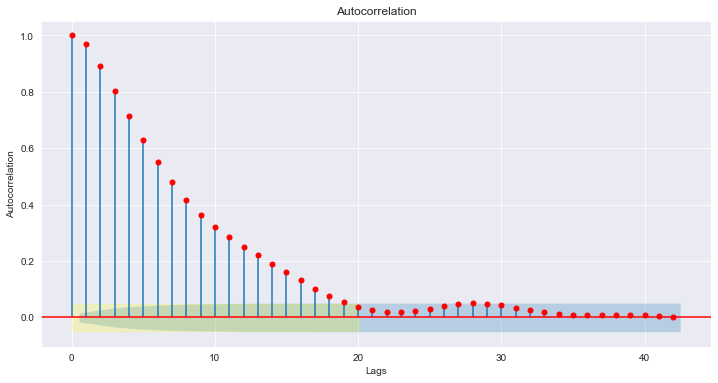

In [109]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(df_autocorrelation["Measurement"], ax=ax, color = "red")
ax.fill_between(np.arange(0, 21), -1.96/np.sqrt(len(df_autocorrelation2["Measurement"])), 1.96/np.sqrt(len(df_autocorrelation2["Measurement"])), color='yellow', alpha=0.2)
plt.xlabel("Lags")
plt.ylabel("Autocorrelation")
plt.show()

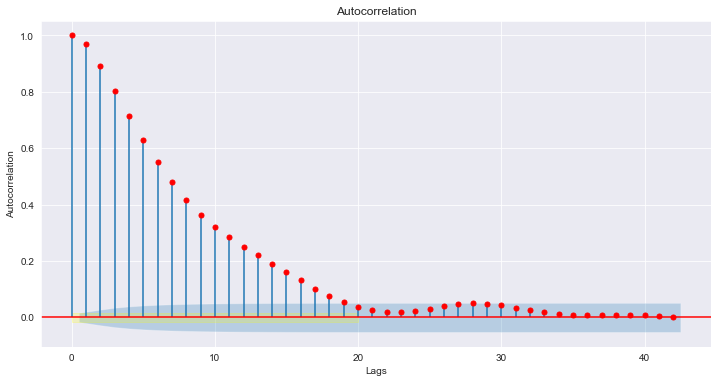

In [83]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(df_autocorrelation["Measurement"], ax=ax, color = "red")
ax.fill_between(np.arange(0, 21), -1.96/np.sqrt(len(df_autocorrelation["Measurement"])), 1.96/np.sqrt(len(df_autocorrelation["Measurement"])), color='yellow', alpha=0.2)
plt.xlabel("Lags")
plt.ylabel("Autocorrelation")
plt.show()

In [85]:
# Exporting the preprocessing dataset

df_glucose.to_csv('data_preprocessed.csv')